<a href="https://colab.research.google.com/github/gazalpatel/REINFORCE/blob/main/week_4_the_final_trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custome Reward Trials - R1 + R2 - Cart Position + Pole Angle

Episode 50	Average Reward: 26.48
Episode 100	Average Reward: 67.66
Episode 150	Average Reward: 172.74

Environment solved in 193 episodes with average reward 195.54 over the last 50.00 episodes.


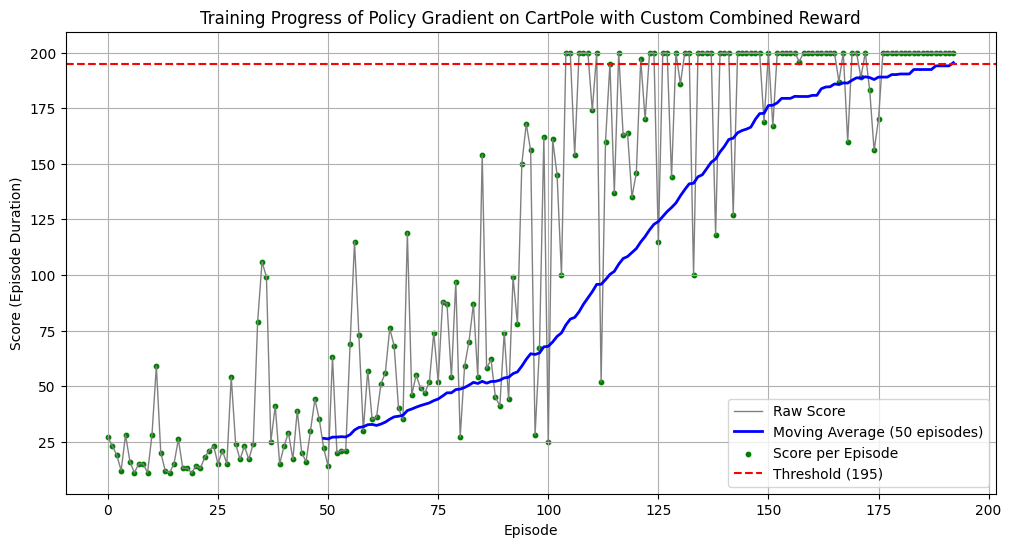

Test Scores Summary:
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True    100
Name: count, dtype: int64


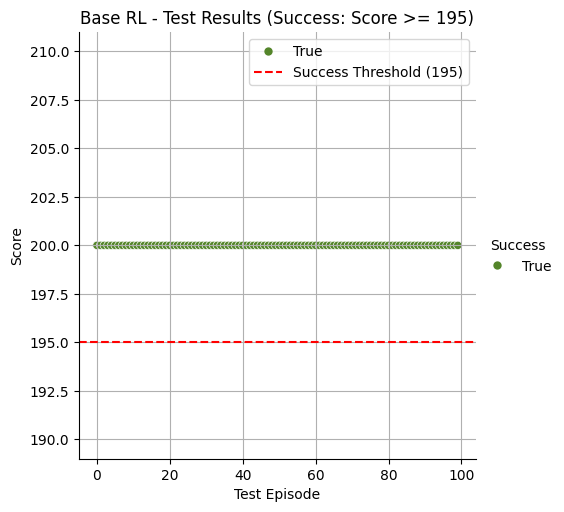

In [7]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym, random
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 2
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, _, done, _ = env.step(action.item())

        # Extract state variables
        x = abs(next_state[0])  # Cart position (absolute value)
        theta = abs(next_state[2])  # Pole angle (absolute value)

        # Compute custom rewards
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = (0.2 * cart) + (0.8 * angle)  # Combined reward

        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break

    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(t + 1)
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")
        
    convergence_criteria = 50
    # Check for convergence
    if episode >= convergence_criteria:
        avg_reward = np.mean(episode_rewards[-convergence_criteria:])
        if avg_reward >= 195.0:
            print(f"\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last {convergence_criteria:.2f} episodes.")
            break

# Close the environment
env.close()

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of Policy Gradient on CartPole with Custom Combined Reward')
plt.legend()
plt.grid(True)
plt.show()


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to sample action based on the trained policy
def test_policy_sample(state, policy_net):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_base_rl(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)
    
    rewards = []

    for t in range(200):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_base_rl(method='Base RL', total_tests=100):
    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_base_rl(i, print_reward=False))

    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the testing and plotting function
plot_test_results_base_rl(method="Base RL", total_tests=100)


Test Scores Summary:
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True    100
Name: count, dtype: int64


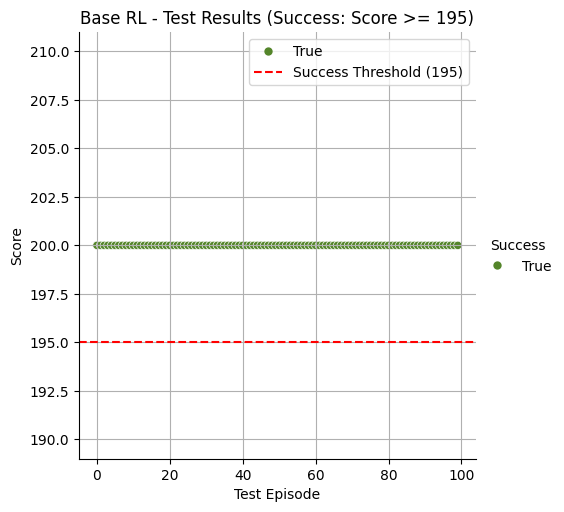

In [3]:
plot_test_results_base_rl(method="Base RL", total_tests=100)

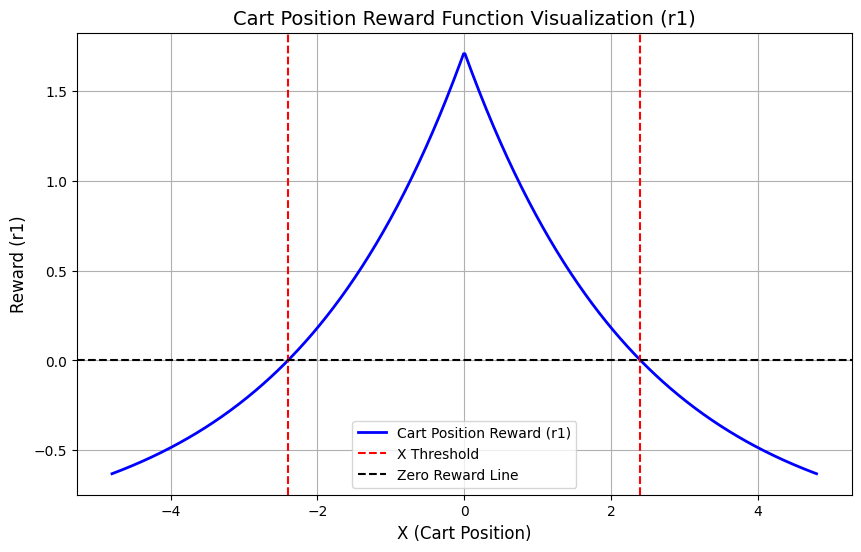

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the cart position reward function
def cart_position_reward(x, x_threshold):
    """
    Computes the reward based on the formula:
    r1 = e^((x_threshold - |x|) / x_threshold) - 0.8
    """
    return np.exp((x_threshold - np.abs(x)) / x_threshold) - 0.999

# Parameters
x_threshold = 2.4  # Cart position threshold for CartPole (in meters)
x_values = np.linspace(-2 * x_threshold, 2 * x_threshold, 500)  # Generate x values

# Compute rewards for each cart position
rewards_r1 = cart_position_reward(x_values, x_threshold)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(x_values, rewards_r1, label='Cart Position Reward (r1)', color='blue', linewidth=2)
plt.axvline(x=x_threshold, color='red', linestyle='--', label='X Threshold')
plt.axvline(x=-x_threshold, color='red', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Reward Line')

# Labels and title
plt.title("Cart Position Reward Function Visualization (r1)", fontsize=14)
plt.xlabel("X (Cart Position)", fontsize=12)
plt.ylabel("Reward (r1)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


# Custome Reward Trials - R2 - Pole Angle

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 41.28
Episode 100	Average Reward: 128.86
Episode 150	Average Reward: 151.06
Episode 200	Average Reward: 185.86
Episode 250	Average Reward: 195.58

Environment solved in 268 episodes with average reward 195.07 over the last 100 episodes.


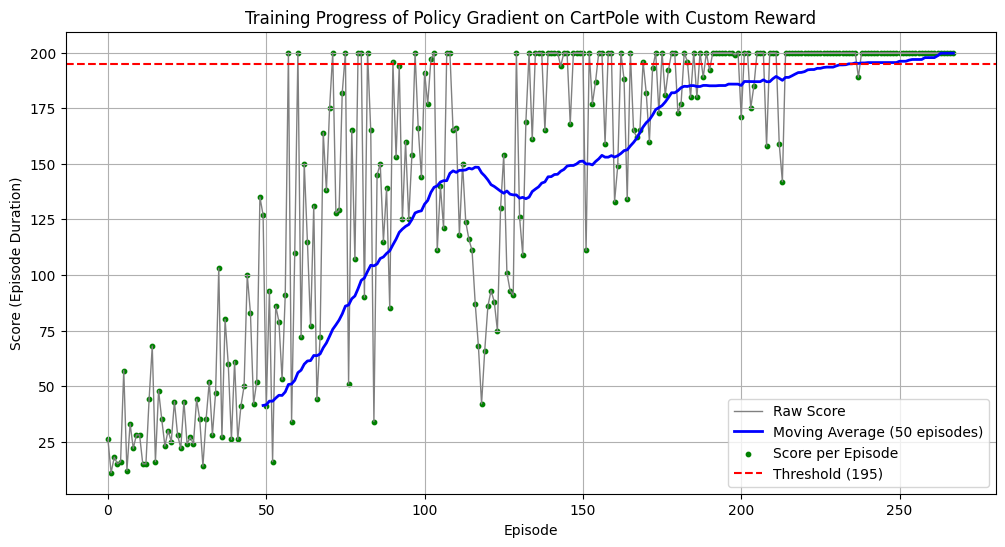

In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Get theta threshold from environment constraints
theta_threshold = (env.observation_space.high[2])/2 - 0.001

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())

        # Compute custom reward
        theta = abs(next_state[2])  # Pole angle (absolute value)
        reward = np.exp(theta_threshold - theta) / theta_threshold - 0.999  # Custom reward

        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break

    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(t+1)
    # Print progress every 10 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of Policy Gradient on CartPole with Custom Reward')
plt.legend()
plt.grid(True)
plt.show()


Test Scores Summary:
count    500.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True    500
Name: count, dtype: int64


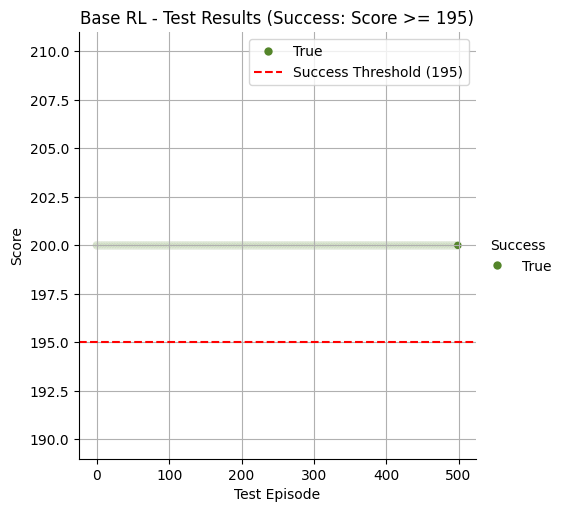

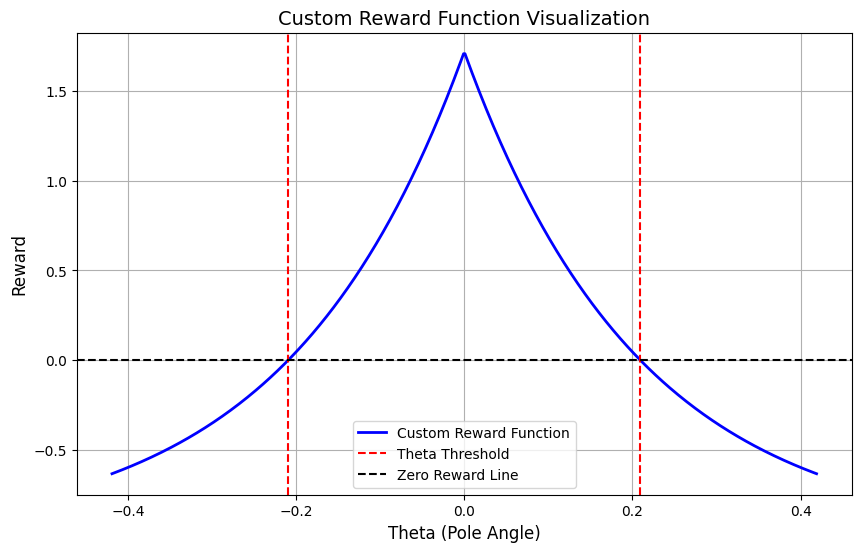

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom reward function
def custom_reward(theta, theta_threshold):
    """
    Computes the reward based on the formula:
    r = e^((theta_threshold - |theta|) / theta_threshold)
    """
    return np.exp((theta_threshold - np.abs(theta)) / theta_threshold) - 0.9999

# Parameters
theta_threshold = 0.20943951  # Pole angle threshold (in radians, ~12 degrees for CartPole)
theta_values = np.linspace(-2 * theta_threshold, 2 * theta_threshold, 500)  # Generate theta values

# Compute rewards for each theta
rewards = custom_reward(theta_values, theta_threshold)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(theta_values, rewards, label='Custom Reward Function', color='blue', linewidth=2)
plt.axvline(x=theta_threshold, color='red', linestyle='--', label='Theta Threshold')
plt.axvline(x=-theta_threshold, color='red', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Reward Line')

# Labels and title
plt.title("Custom Reward Function Visualization", fontsize=14)
plt.xlabel("Theta (Pole Angle)", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


In [ ]:
theta = 0
theta_threshold = (env.observation_space.high[2])/2 - 0.001
theta = abs(next_state[2])  # Pole angle (absolute value)
reward = (theta_threshold - theta) / theta_threshold - 0.5
print(theta_threshold)
print(reward)

0.20843951606750488
tensor(0.4264)


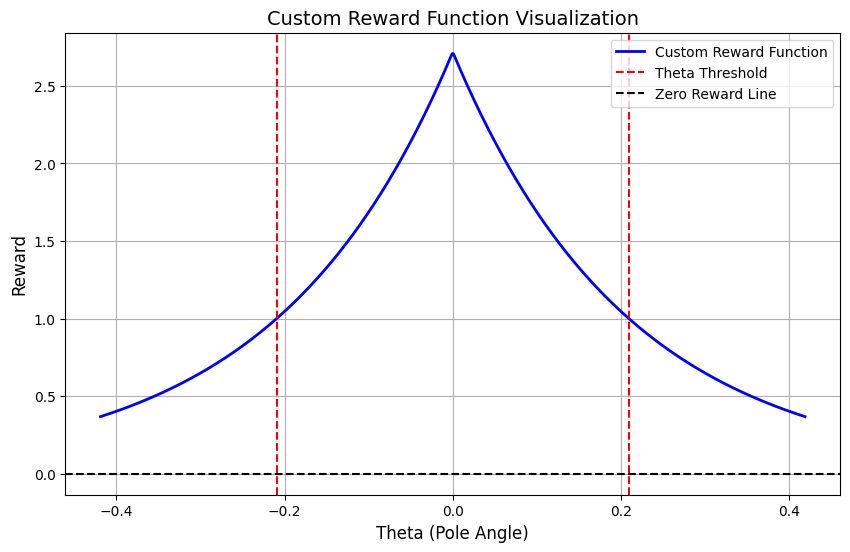

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom reward function
def custom_reward(theta, theta_threshold):
    """
    Computes the reward based on the formula:
    r = e^((theta_threshold - |theta|) / theta_threshold)
    """
    return np.exp((theta_threshold - np.abs(theta)) / theta_threshold)

# Parameters
theta_threshold = 0.20943951  # Pole angle threshold (in radians, ~12 degrees for CartPole)
theta_values = np.linspace(-2 * theta_threshold, 2 * theta_threshold, 500)  # Generate theta values

# Compute rewards for each theta
rewards = custom_reward(theta_values, theta_threshold)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(theta_values, rewards, label='Custom Reward Function', color='blue', linewidth=2)
plt.axvline(x=theta_threshold, color='red', linestyle='--', label='Theta Threshold')
plt.axvline(x=-theta_threshold, color='red', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Reward Line')

# Labels and title
plt.title("Custom Reward Function Visualization", fontsize=14)
plt.xlabel("Theta (Pole Angle)", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


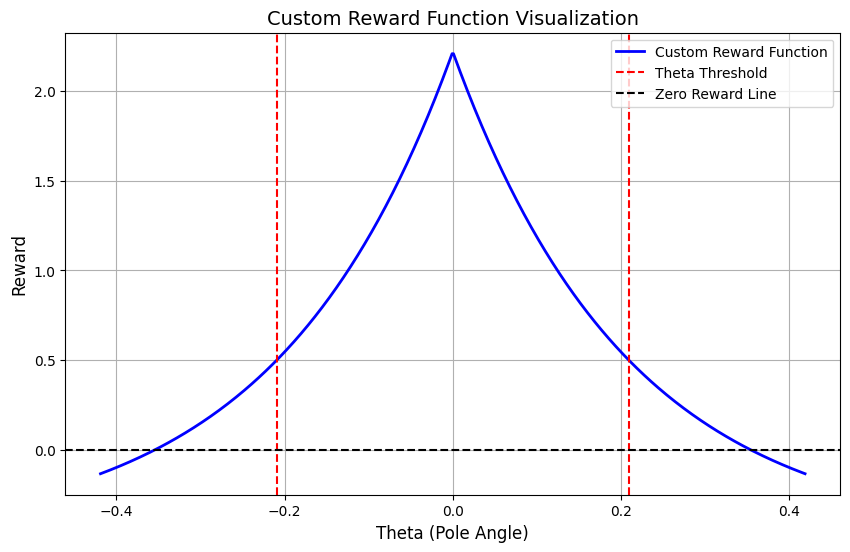

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom reward function
def custom_reward(theta, theta_threshold):
    """
    Computes the reward based on the formula:
    r = e^((theta_threshold - |theta|) / theta_threshold)
    """
    return np.exp((theta_threshold - np.abs(theta)) / theta_threshold) - 0.5

# Parameters
theta_threshold = 0.20943951  # Pole angle threshold (in radians, ~12 degrees for CartPole)
theta_values = np.linspace(-2 * theta_threshold, 2 * theta_threshold, 500)  # Generate theta values

# Compute rewards for each theta
rewards = custom_reward(theta_values, theta_threshold)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(theta_values, rewards, label='Custom Reward Function', color='blue', linewidth=2)
plt.axvline(x=theta_threshold, color='red', linestyle='--', label='Theta Threshold')
plt.axvline(x=-theta_threshold, color='red', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Reward Line')

# Labels and title
plt.title("Custom Reward Function Visualization", fontsize=14)
plt.xlabel("Theta (Pole Angle)", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


In [ ]:
def step(self, action):
    # Original step function
    obs, reward, done, info = super(CustomCartPoleEnv, self).step(action)
    # Modify the reward
    x, x_dot, theta, theta_dot = obs
    # Penalize the cart for being away from center
    # 0 to 005
    reward -= abs(x) * 0.1
    # Penalize the pole angle deviation
    reward -= abs(theta) * 0.5
    return obs, reward, done, info

# 1. Best hyperparameter combination model

---


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 41.90
Episode 100	Average Reward: 107.22
Episode 150	Average Reward: 182.28
Episode 200	Average Reward: 183.70
Episode 250	Average Reward: 173.50
Episode 300	Average Reward: 199.56

Environment solved in 328 episodes with average reward 195.12 over the last 100 episodes.


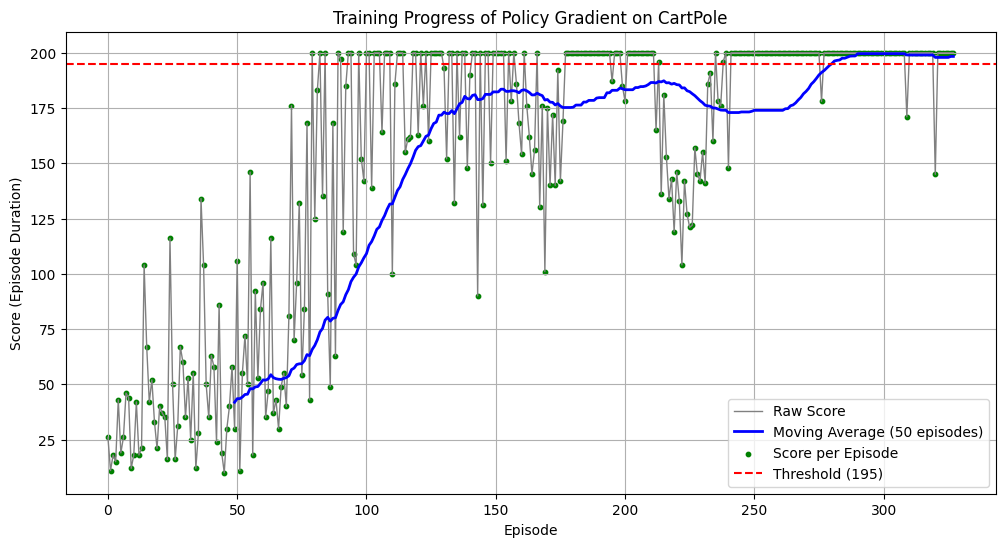

In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 10 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()


import matplotlib.pyplot as plt
import numpy as np

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of Policy Gradient on CartPole')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Test Scores Summary:
count    100.00000
mean     196.22000
std       16.73174
min       82.00000
25%      200.00000
50%      200.00000
75%      200.00000
max      200.00000
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True     92
False     8
Name: count, dtype: int64


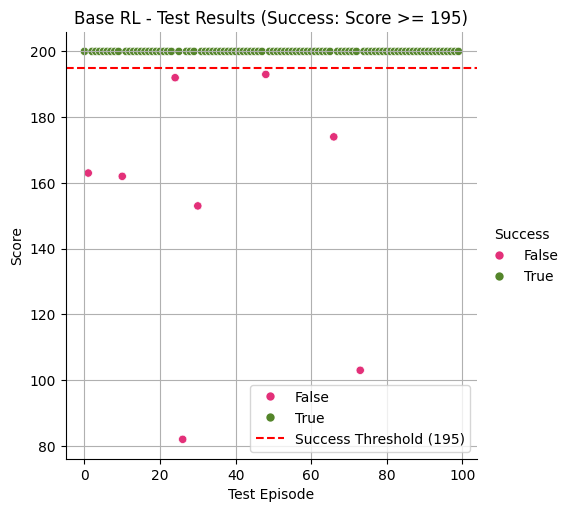

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to sample action based on the trained policy
def test_policy_sample(state, policy_net):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_base_rl(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    rewards = []

    for t in range(200):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_base_rl(method='Base RL', total_tests=100):
    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_base_rl(i, print_reward=False))

    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the testing and plotting function
plot_test_results_base_rl(method="Base RL", total_tests=100)


# 3. PPO Trials

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50, Average Reward: 93.92
Episode 100, Average Reward: 169.78
Episode 150, Average Reward: 183.98
Episode 200, Average Reward: 171.44
Episode 250, Average Reward: 191.26
Episode 300, Average Reward: 189.52
Episode 350, Average Reward: 188.10
Episode 400, Average Reward: 190.40
Episode 450, Average Reward: 192.88
Episode 500, Average Reward: 191.04
Episode 550, Average Reward: 175.06
Episode 600, Average Reward: 165.10
Episode 650, Average Reward: 193.94
Episode 700, Average Reward: 187.62
Episode 750, Average Reward: 185.26
Episode 800, Average Reward: 187.14
Episode 850, Average Reward: 185.88
Episode 900, Average Reward: 196.08
Episode 950, Average Reward: 187.96
Episode 1000, Average Reward: 193.02


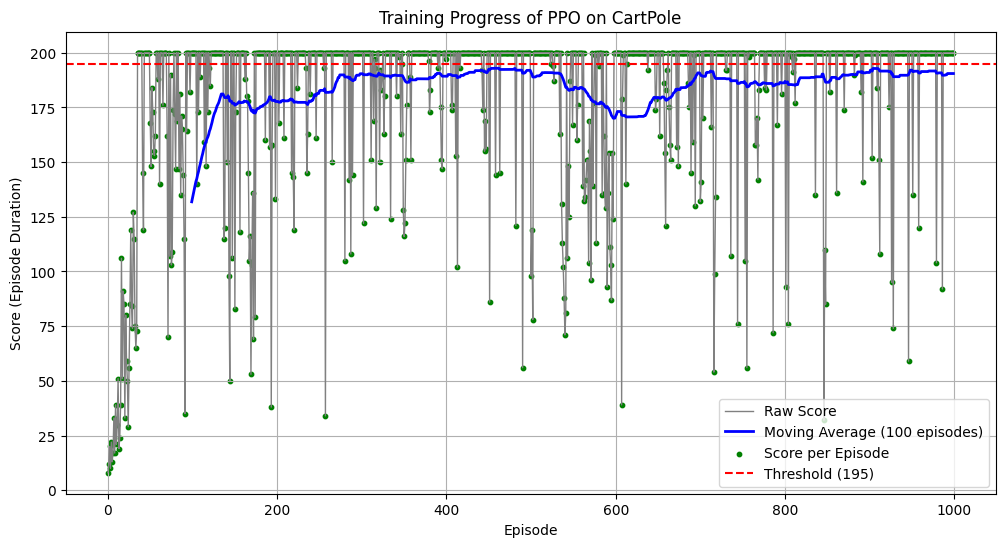

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
SEED = 20
np.random.seed(SEED)
torch.manual_seed(SEED)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(SEED)

# Hyperparameters
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 64
learning_rate = 0.003
gamma = 0.99
epsilon_clip = 0.2
k_epochs = 4
num_episodes = 1000
max_steps = 500
batch_size = 32

# Define the Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        state_value = self.critic(state)
        return action_probs, state_value

# Initialize the Actor-Critic model
policy = ActorCritic(state_dim, action_dim, hidden_dim).to('cpu')
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

# PPO Loss function
def compute_ppo_loss(old_log_probs, new_log_probs, advantages, values, returns):
    ratios = torch.exp(new_log_probs - old_log_probs)
    clipped_ratios = torch.clamp(ratios, 1 - epsilon_clip, 1 + epsilon_clip)
    actor_loss = -torch.min(ratios * advantages, clipped_ratios * advantages).mean()
    critic_loss = nn.MSELoss()(returns, values)
    return actor_loss + 0.5 * critic_loss

# Training Loop
episode_rewards = []
for episode in range(1, num_episodes + 1):
    state = env.reset()
    states, actions, rewards, log_probs, values, dones = [], [], [], [], [], []
    total_reward = 0

    # Collect trajectory
    for _ in range(max_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_probs, state_value = policy(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_state, reward, done, _ = env.step(action.item())
        total_reward += reward

        # Store experience
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob)
        values.append(state_value)
        dones.append(done)

        state = next_state
        if done:
            break

    # Compute returns and advantages
    returns = []
    advantages = []
    G = 0
    for r, value, done in zip(reversed(rewards), reversed(values), reversed(dones)):
        if done:
            G = 0
        G = r + gamma * G
        returns.insert(0, G)
        advantages.insert(0, G - value.item())

    returns = torch.FloatTensor(returns)
    advantages = torch.FloatTensor(advantages)
    log_probs = torch.cat(log_probs)
    values = torch.cat(values).squeeze()

    # Optimize policy using PPO
    for _ in range(k_epochs):
        for i in range(0, len(states), batch_size):
            # Prepare mini-batches
            state_batch = torch.FloatTensor(states[i:i + batch_size])
            action_batch = torch.tensor(actions[i:i + batch_size])
            advantage_batch = advantages[i:i + batch_size].detach()  # Detach
            return_batch = returns[i:i + batch_size].detach()  # Detach
            old_log_probs_batch = log_probs[i:i + batch_size].detach()  # Detach

            # Recompute log_probs and state values
            action_probs, state_values = policy(state_batch)
            dist = Categorical(action_probs)
            new_log_probs = dist.log_prob(action_batch)

            # Compute PPO loss
            loss = compute_ppo_loss(
                old_log_probs_batch,
                new_log_probs,
                advantage_batch,
                state_values.squeeze(),
                return_batch
            )

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Logging
    episode_rewards.append(total_reward)
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
        print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")

    # Early stopping condition
    if len(episode_rewards) >= 100 and np.mean(episode_rewards[-100:]) >= 195.6:
        print(f"\nEnvironment solved in {episode} episodes with average reward {np.mean(episode_rewards[-100:]):.2f} over the last 100 episodes.")
        break

# Plot Rewards using the template style
score_array = np.array(episode_rewards)
window_size = 100  # Moving average window size
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
else:
    moving_avg = score_array

plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of PPO on CartPole')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Test Scores Summary:
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True    100
Name: count, dtype: int64


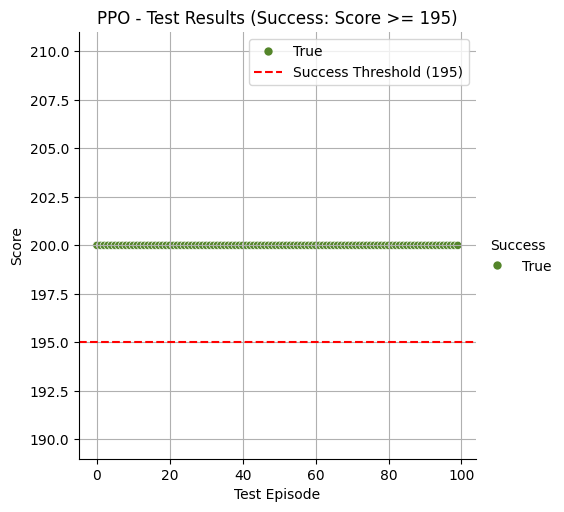

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to sample action based on the trained policy
def test_ppo_policy_sample(state, policy):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs, _ = policy(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_ppo(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    rewards = []

    for t in range(200):
        action = test_ppo_policy_sample(state, policy)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_ppo(method='PPO', total_tests=100):
    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_ppo(i, print_reward=False))

    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the testing and plotting function
plot_test_results_ppo(method="PPO", total_tests=100)


# 4. V10 PPO with entropy, LR Sched, BS, Epoch, CVLW

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50, Average Reward: 54.54
Episode 100, Average Reward: 159.62
Episode 150, Average Reward: 183.04
Episode 200, Average Reward: 195.14

Environment solved in 206 episodes with average reward 195.92 over the last 50 episodes.


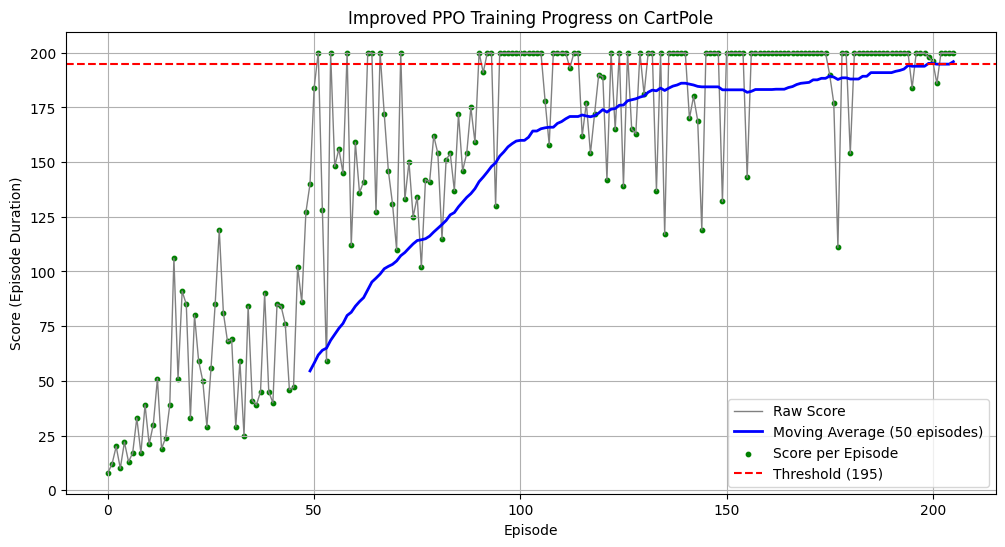

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
SEED = 20
np.random.seed(SEED)
torch.manual_seed(SEED)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(SEED)

# Hyperparameters
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 64
learning_rate = 0.003
gamma = 0.99
epsilon_clip = 0.2
k_epochs = 4
num_episodes = 1000
max_steps = 500
batch_size = 32

# Define the Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        state_value = self.critic(state)
        return action_probs, state_value

# Initialize the Actor-Critic model
policy = ActorCritic(state_dim, action_dim, hidden_dim).to('cpu')
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)


# PPO Loss function with Entropy Regularization
def compute_ppo_loss_with_entropy(old_log_probs, new_log_probs, advantages, values, returns, action_probs, entropy_coeff=0.01):
    ratios = torch.exp(new_log_probs - old_log_probs)
    clipped_ratios = torch.clamp(ratios, 1 - epsilon_clip, 1 + epsilon_clip)
    actor_loss = -torch.min(ratios * advantages, clipped_ratios * advantages).mean()
    critic_loss = nn.MSELoss()(returns, values)
    entropy_loss = -torch.mean(torch.sum(action_probs * torch.log(action_probs + 1e-10), dim=1))  # Add entropy regularization
    return actor_loss + 0.5 * critic_loss + entropy_coeff * entropy_loss  # Weight for entropy term

# Training Loop
episode_rewards = []
for episode in range(1, num_episodes + 1):
    state = env.reset()
    states, actions, rewards, log_probs, values, dones = [], [], [], [], [], []
    total_reward = 0

    # Collect trajectory
    for _ in range(max_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_probs, state_value = policy(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_state, reward, done, _ = env.step(action.item())
        total_reward += reward

        # Store experience
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob)
        values.append(state_value)
        dones.append(done)

        state = next_state
        if done:
            break

    # Compute returns and advantages
    returns = []
    advantages = []
    G = 0
    for r, value, done in zip(reversed(rewards), reversed(values), reversed(dones)):
        if done:
            G = 0
        G = r + gamma * G
        returns.insert(0, G)
        advantages.insert(0, G - value.item())

    returns = torch.FloatTensor(returns)
    advantages = torch.FloatTensor(advantages)
    log_probs = torch.cat(log_probs)
    values = torch.cat(values).squeeze()

    # Optimize policy using PPO with entropy regularization
    for _ in range(k_epochs):
        for i in range(0, len(states), batch_size):
            # Prepare mini-batches
            state_batch = torch.FloatTensor(states[i:i + batch_size])
            action_batch = torch.tensor(actions[i:i + batch_size])
            advantage_batch = advantages[i:i + batch_size].detach()  # Detach
            return_batch = returns[i:i + batch_size].detach()  # Detach
            old_log_probs_batch = log_probs[i:i + batch_size].detach()  # Detach

            # Recompute log_probs and state values
            action_probs, state_values = policy(state_batch)
            dist = Categorical(action_probs)
            new_log_probs = dist.log_prob(action_batch)

            # Compute PPO loss
            loss = compute_ppo_loss_with_entropy(
                old_log_probs_batch,
                new_log_probs,
                advantage_batch,
                state_values.squeeze(),
                return_batch,
                action_probs
            )

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Logging
    episode_rewards.append(total_reward)
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
        print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")

    # Early stopping condition
    if len(episode_rewards) >= 50 and np.mean(episode_rewards[-50:]) >= 195.6:
        print(f"\nEnvironment solved in {episode} episodes with average reward {np.mean(episode_rewards[-50:]):.2f} over the last 50 episodes.")
        break

# Plot Rewards
score_array = np.array(episode_rewards)
window_size = 50  # Moving average window size
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
else:
    moving_avg = score_array

plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Improved PPO Training Progress on CartPole')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Test scores: [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success
True    100
Name: count, dtype: int64


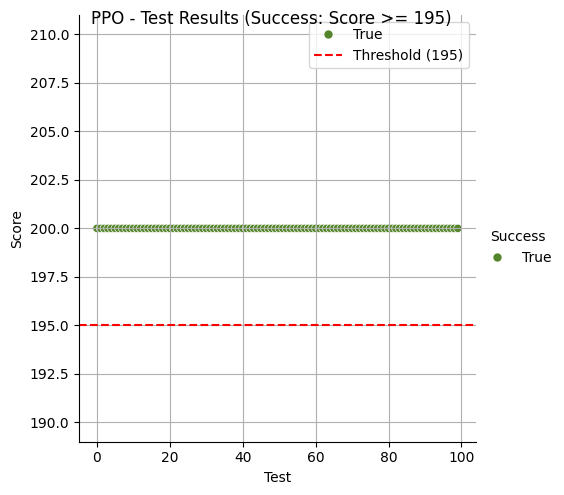

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to test the PPO agent
def test_ppo_agent(policy, i, print_reward=False):
    # Create a test environment
    env = gym.make('CartPole-v0')
    env.seed(i)
    state = env.reset()
    total_reward = 0

    for t in range(200):  # Fixed max steps for testing
        # Get action probabilities from the trained policy
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_probs, _ = policy(state_tensor)
        action = torch.argmax(action_probs).item()  # Select the action with the highest probability
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break

    env.close()
    if print_reward:
        print(f"Reward: {total_reward}")
    return total_reward

# Function to plot test results
def plot_test_results(method='', total=100):
    test_scores = []
    for i in range(total):
        test_scores.append(test_ppo_agent(policy, i, print_reward=False))

    print(f"Test scores: {test_scores}")

    # Define success as achieving a score >= 195
    colors = {True: "#54852A", False: "#E33079"}
    test_df = pd.DataFrame({'Test': range(total), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195

    # Print statistics
    print(test_df['Score'].describe())
    success_count = test_df['Success'].value_counts()
    print(success_count)

    # Plot results
    ax = sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    ax.fig.suptitle(f"{method} - Test Results (Success: Score >= 195)")
    plt.axhline(y=195, color='r', linestyle='--', label='Threshold (195)')
    plt.legend()
    plt.grid()
    plt.show()

# Test and plot results
plot_test_results(method='PPO', total=100)


In [3]:
# !pip install SumTree

In [ ]:
import os
import random
import gym
import numpy as np
from collections import deque
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend as K


# Custom Experience Replay Buffer with Prioritized Experience Replay
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree):
            return idx
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, p)
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]
        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]


class Memory:
    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def store(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []
        for i in range(n):
            s = random.uniform(segment * i, segment * (i + 1))
            idx, p, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)
        sampling_probabilities = priorities / self.tree.total()
        is_weights = np.power(self.tree.capacity * sampling_probabilities, -0.6)
        is_weights /= is_weights.max()
        return batch, idxs, is_weights

    def batch_update(self, idxs, errors):
        for idx, error in zip(idxs, errors):
            p = self._get_priority(error)
            self.tree.update(idx, p)

    def _get_priority(self, error):
        return (np.abs(error) + 1e-6) ** 0.6


class DQNAgent:
    def __init__(self, state_size, action_size, memory_size=2000, batch_size=24, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001, use_per=True):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = Memory(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.use_per = use_per
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        inputs = Input(shape=(self.state_size,))
        x = Dense(24, activation='relu')(inputs)
        x = Dense(24, activation='relu')(x)
        outputs = Dense(self.action_size, activation='linear')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory.tree.data) < self.batch_size:
            return
        minibatch, idxs, is_weights = self.memory.sample(self.batch_size)
        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []
        for i in range(self.batch_size):
            states[i] = minibatch[i][0]
            actions.append(minibatch[i][1])
            rewards.append(minibatch[i][2])
            next_states[i] = minibatch[i][3]
            dones.append(minibatch[i][4])
        targets = self.model.predict(states)
        next_targets = self.target_model.predict(next_states)
        errors = np.zeros(self.batch_size)
        for i in range(self.batch_size):
            if dones[i]:
                errors[i] = rewards[i] - targets[i][actions[i]]
                targets[i][actions[i]] = rewards[i]
            else:
                errors[i] = rewards[i] + self.gamma * np.amax(next_targets[i]) - targets[i][actions[i]]
                targets[i][actions[i]] = rewards[i] + self.gamma * np.amax(next_targets[i])
        self.model.fit(states, targets, epochs=1, verbose=2)
        # Update the priorities in the replay memory
        self.memory.batch_update(idxs, errors.tolist())


    def remember(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = (reward + self.gamma * np.amax(self.target_model.predict(next_state)[0]))
        error = np.abs(target - np.amax(self.model.predict(state)[0]))
        self.memory.store(error, (state, action, reward, next_state, done))


# Main Training Loop
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

episodes = 500
scores = []
moving_avg_scores = []
last_50_scores = deque(maxlen=50)

for e in range(episodes):
    state = env.reset()
    env.seed(e)
    state = np.reshape(state, [1, state_size])
    done = False
    score = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        score += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            agent.update_target_model()
            break
        agent.replay()
    scores.append(score)
    last_50_scores.append(score)
    moving_avg_scores.append(np.mean(last_50_scores))
    if e % 50 == 0:
        print(f"Episode {e}, Score: {score}, Avg(Last 50): {np.mean(last_50_scores):.2f}, Epsilon: {agent.epsilon:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(scores, color='gray', label='Raw Scores')
plt.plot(moving_avg_scores, color='blue', linewidth=2, label='50-Episode Moving Average')
plt.scatter(range(len(scores)), scores, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.title('DQN with PER Performance on CartPole')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 - 0s - 308ms/step - loss: 0.5170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 - 0s - 9ms/step - loss: 0.5209
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 - 0s - 9ms/step - loss: 0.5359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 - 0s - 11ms/step - loss: 0.5317
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 - 0s - 8ms/step - loss: 0.5183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/